In [1]:
# Goal of this notebook is to implement the dynamical model of Neggers et al. (2006).
# Figure 4 of Neggers et al. (2006) is reproduced, but the equilibrium values do not coincide with theirs.
# They coincide with those published by Youtong Zheng here https://github.com/youtongzheng/Neggers_2006.

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts/ABL_BULK/')

## these files contain all functions definiing bulk model, saturation humidities, LCL ...
import neggers_2006
import neggers_stevens

In [2]:
%load_ext autoreload
%autoreload 2

# Neggers et al. (2006) model

The model numerically solves the following three equations for the ABL height $h$, total specific humidity $q_t$ and liquid water potential temperature $\theta_l$
$$ \frac{\partial h}{\partial t} = E + w - M $$
$$ h\frac{\partial q_t}{\partial t} = \overline{w'q_t'}_s + E \Delta q_t + hF_{adv,q_t} $$
$$ h\frac{\partial \theta_l}{\partial t} = \overline{w'\theta_l'}_s + E\Delta\theta_l + hF_{adv,\theta_l} + hF_{rad}, $$
where the surface fluxes are represented with the bulk formulae
$$\overline{w'q_t'}_s = |\boldsymbol{u}_s|C_q^s(q_t^s-q_t)$$
$$\overline{w'\theta_l'}_s = |\boldsymbol{u}_s|C_\theta^s(\theta_l^s-\theta_l)$$
with  $C_q^s = C_\theta^s = 0.0012$, $\boldsymbol{u}_s$ being the surface wind and $q_t^s$ and $\theta_l^s$ the surface properties. The symbol $\Delta$ denotes the jump across the transition layer and not the difference between the free atmosphere and ABL values.

Remind that the liquid water potential temperature can be approximated with 
$$ \theta_l = \theta - \frac{L_v}{c_{pd}}r_l,$$
with $L_v$ the latent heat of vaporization, $c_{pd}$ the specific heat of dry air at constant pressure and $r_l$ the liquid water mixing ratio.

Starting from the equation for $h$, the entrainment $E$ has the units of a velocity and it appears in the virtual potential temperature flux at the ABL top as
$$\overline{w'\theta_v'}_h = E\Delta\theta. $$
From the definition of virtual potential temperature, $\theta_v = \theta(1+0.61q_t-1.61q_l)$, assuming no liquid water, $q_l = 0$, the jump in $\theta_v$ at the ABL top can be explicitly written as
$$\Delta\theta_v = \Delta\theta+ 0.61(\theta\Delta q_t+q_t\Delta\theta+\Delta q_t\Delta\theta).$$

The transition layer jumps are related to the difference w.r.t. the free atmospheric values with some transfer coefficients that represent the cloud layer
$$\Delta q_t = C_q^c (q_t^+-q_t)$$
$$\Delta \theta_l = C_\theta^c (\theta_l^+-\theta_l),$$
with $C_q^c = 0.1$ and $C_\theta^c = 0.03$ from LES hourly mean profiles.

Similarly, the link between the virtual potential temperature flux and the other fluxes is 
$$\overline{w'\theta_v'} = (1+0.61q_t)\overline{w'\theta_l'} + 0.61\theta\overline{w'q_t'}$$
(Cuijpers and Betchold, 1995), neglecting the liquid water specific humidity term.

But the ABL top virtual potential temperature flux has been shown to be proportional to the surface virtual potential temperature flux as
$$ \overline{w'\theta_v'}_h = -0.2 \overline{w'\theta_v'}_s. $$
Thus, the entrainment can be written as 
$$ E = 0.2\frac{\overline{w'\theta_v'}_s}{\Delta\theta_v} $$

The vertical velocity at the ABL top, $w$, is easily imposed as a boundary condition, knowing the large scale subsidence $D$, through mass conservation, namely
$$ w = -hD .$$

The mass flux term $M$ is parameterized as the product of a vertical velocity scale, which has been identified with the Deardorff convective velocity scale $w_*$, and a fractional area of shallow convection $a_c$. Thus,
$$ M = a_cw_*,$$
with 
$$ w_* = (h\overline{w'b'}_s)^{1/3}, $$
$\overline{w'b'}_s = g\overline{w'\theta_v'}_s/\theta_v$ being the surface buoyancy flux. The moist convective area fraction is written as a function of the normalized saturation deficit at the ABL top, namely
$$a_c = 0.5 + 0.36 \arctan\left(1.55\frac{q_t-q_{sat}}{\sigma_q}\right),$$
where $q_{sat}$ is the saturation specific humidity at the ABL top and $\sigma_q^2$, the specific humidity turbulent variance at the ABL top, can be expressed as
$$ \sigma_q^2 = -\frac{h}{w_*}\frac{\Delta q_t}{\Delta z}\overline{w'q_t'}_s.$$
$\Delta z=100$ m is the estimated depth of the cloud transition layer.

In [3]:
# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_2006.qsea(SST-273.15,ps)*1e-3
q_BL = q_s - q_free   # initial BL moisture; Ale added, 6th Feb 2025

# Input parameters
V = 8.75 # [m/s], large scale horizontal wind
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
ps = 1015 # [hPa], surface pressure

# initial conditions vector  
y0 = [100,q_BL,th_s-2]     

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0

dict_ext_N06 = {'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[], \
                    'LHF_ext':[], 'LHF_CC_ext':[], 'qs_ext':[], 'qsat_ext':[], 'sigma_q_ext':[], 'SHF_ext':[], 'LCL_ext':[] }
sol_N06 = solve_ivp(neggers_2006.neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps, dict_ext_N06))#, t_eval=t_eval)

equilibrium h = 557.85 m
equilibrium LCL = 734.42 m
equilibrium q = 16.04 g/kg
equilibrium th = 299.17 K
equilibrium a$_c$ = 4.56%
equilibrium w$\star$ = 0.15 m/s


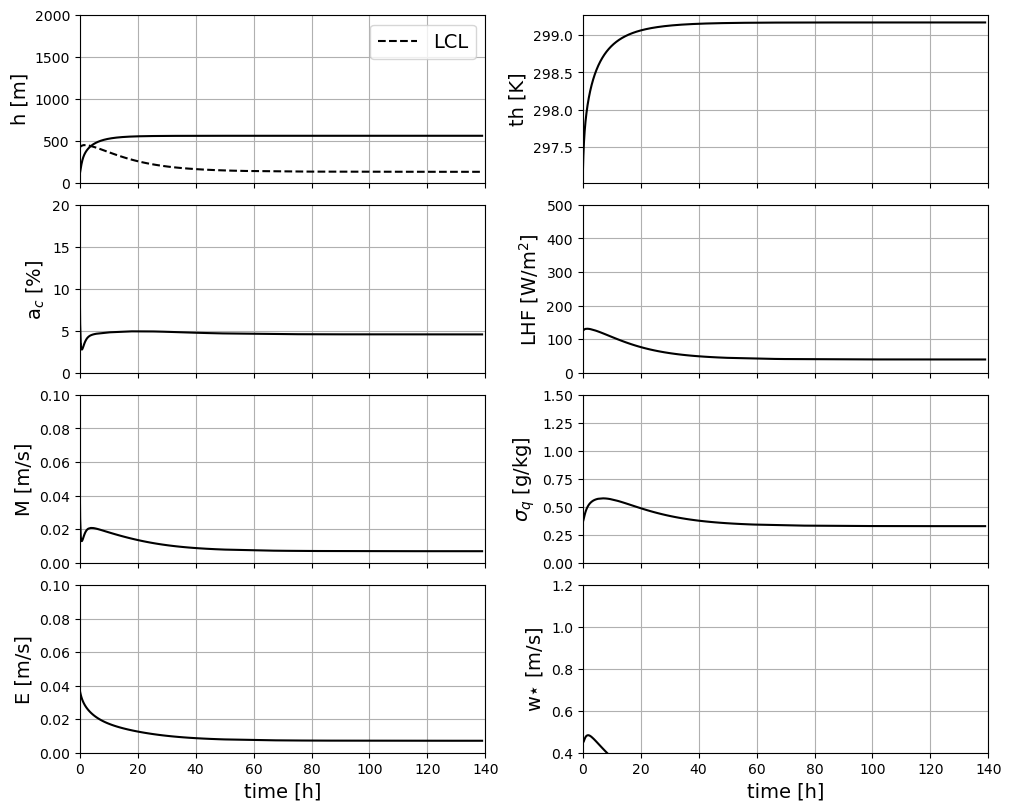

In [21]:
# Plots for a single run.
h = sol_N06.y[0]
q = sol_N06.y[1]
th = sol_N06.y[2]

q_s = neggers_2006.qsea(SST-273.15,ps) # [kg/kg], surface total specific humidity (saturation value)
eq_T0 = th[-1]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
eq_LCL = neggers_2006.lcl(ps*100,eq_T0,q[-1]*1e3/q_s)

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_N06 = np.max(sol_N06.t)
dt_N06 = t_final_N06/3600/len(dict_ext_N06['E_ext']) # [h]
time_ext_N06 = np.arange(len(dict_ext_N06['E_ext']))*dt_N06

print('equilibrium h = '+str(round(h[-1],2))+' m')
print('equilibrium LCL = '+str(round(eq_LCL,2))+' m')
print('equilibrium q = '+str(round(q[-1]*1e3, 2))+' g/kg')
print('equilibrium th = ' +str(round(th[-1], 2))+' K')
print('equilibrium a$_c$ = '+str(round(dict_ext_N06['area_c_ext'][-1]*100, 2))+'%')
print('equilibrium w$\star$ = '+str(round(dict_ext_N06['w_star_ext'][-1],2))+' m/s')

fig, ax = plt.subplots(4,2,figsize=(10,8),sharex=True,constrained_layout=True)

ax[0,0].plot(sol_N06.t/3600,h,'k')
ax[0,0].plot(time_ext_N06,dict_ext_N06['LCL_ext'],'--k',label='LCL')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()
ax[0,0].legend(fontsize=14)

# ax[0,1].plot(sol_N06.t/3600,q*1e3,'k')
# ax[0,1].plot(time_ext_N06,np.array(dict_ext_N06['qs_ext'])*1e3,'-.k',label='q*$_s$')
# ax[0,1].plot(time_ext_N06,np.array(dict_ext_N06['qsat_ext'])*1e3,'--k',label='q*$_h$')
# ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,1].set_ylim(0,25)
# ax[0,1].grid()
# ax[0,1].legend(fontsize=14)

ax[0,1].plot(sol_N06.t/3600,th,'k')
ax[0,1].set_ylabel('th [K]',fontsize=14)
# ax[0,1].xlabel('time [h]',fontsize=14)
ax[0,1].grid()
# ax[0,1].show()

ax[1,0].plot(time_ext_N06,np.array(dict_ext_N06['area_c_ext'])*100,'k')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()

ax[1,1].plot(time_ext_N06,np.array(dict_ext_N06['LHF_ext']),'k')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
ax[1,1].set_ylim(0,500)
ax[1,1].grid()

ax[2,0].plot(time_ext_N06,np.array(dict_ext_N06['M_ext']),'k')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(time_ext_N06,np.array(dict_ext_N06['sigma_q_ext'])*1e3,'k')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

ax[3,0].plot(time_ext_N06,np.array(dict_ext_N06['E_ext']),'k')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].plot(time_ext_N06,np.array(dict_ext_N06['w_star_ext']),'k')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[3,0].set_xlabel('time [h]',fontsize=14)
ax[3,1].set_xlabel('time [h]',fontsize=14)
ax[3,0].set_xlim(0,140)
ax[3,1].set_xlim(0,140)

# Define the variables with constant V(_mag), CV
h_CV = h
q_CV = q
area_c_ext_CV = dict_ext_N06['area_c_ext']
LHF_ext_CV = dict_ext_N06['LHF_ext']
M_ext_CV = dict_ext_N06['M_ext']
sigma_q_ext_CV = dict_ext_N06['sigma_q_ext']
E_ext_CV = dict_ext_N06['E_ext']
w_star_ext_CV = dict_ext_N06['w_star_ext']

In [18]:
th_s

299.12461778927917

In [24]:
# Now test the dependence of the solution to some external parameters.

# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3                   # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67                    # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1                        # J/K/kg, dry air gas constant
SST = 300.4                       # K
ps = 1015                         # [hPa], surface pressure
ref_p = 1000                      # [hPa], reference pressure for the potential temperature
th_s = SST*(ref_p/ps)**(Rd/cpd)   # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_2006.qsea(SST-273.15,ps)*1e-3

y0 = [100,q_s - q_free,th_s-2]

# Input parameters
V = 8.75         # [m/s], large scale horizontal wind
SST = 300.4      # [K], sea surface temperature
D = 4.3e-6       # [1/s], large scale divergence
q_free = 4.0e-3  # [kg/kg] free tropospheric total mixing ratio
th_free = 308    # [K], free tropospheric liquid virtual potential temperature
ps = 1015        # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

# Neggers et al. (2006) forcing values...
V_N06 = 8.75                          # [m/s], large scale horizontal wind
SST_N06 = 300.4                       # [K], sea surface temperature
D_N06 = 4.3e-6                        # [1/s], large scale divergence
q_free_N06 = 4.0e-3                   # [kg/kg] free tropospheric total mixing ratio
th_free_N06 = 308                     # [K], free tropospheric liquid virtual potential temperature
ps_N06 = 1015                         # [hPa], surface pressure
q_s_N06 = neggers_2006.qsea(SST_N06-273.15,ps_N06)*1e-3


# ... and equilibrium values
h_N06 = 692               # m
q_N06 = 15                # g/kg 
a_c_N06 = 4.3             # %
w_star_N06 = 0.75         # m/s
M_N06 = 0.032             # m/s

# Set a single parameter to change. Remember to change the name of the variable in the following for loop.
# str_variable = 'V'; list_of_values = np.arange(5,15,1); str_units = 'm/s'; x_N06 = V_N06
# str_variable = 'SST'; list_of_values = np.arange(300,310,0.5); str_units = 'K'; x_N06 = SST_N06
#str_variable = 'D'; list_of_values = np.arange(2.5,6.5,0.25)*1e-6; str_units = '1/s'; x_N06 = D_N06
#str_variable = 'q_free'; list_of_values = np.arange(2.0e-3,4.0e-3,0.2e-3); str_units = 'kg/kg'; x_N06 = q_free_N06
#str_variable = 'th_free'; list_of_values = np.arange(302,312); str_units = 'K'; x_N06 = th_free_N06
#str_variable = 'ps'; list_of_values = np.arange(1000,1030,5); str_units = 'hPa'; x_N06 = ps_N06


dict_params = {
        'SST': {'values': np.arange(300,310,0.5), 'units': 'K', 'forcing_N06': SST_N06},
        'V': {'values': np.arange(5,15), 'units': 'm/s', 'forcing_N06': V_N06},
        'D': {'values': np.arange(2.5,6.5,0.25)*1e-6, 'units': '1/s', 'forcing_N06': D_N06},
        'q_free': {'values': np.arange(0.5e-3,4.0e-3,0.2e-3), 'units': 'kg/kg', 'forcing_N06': q_free_N06},
        'th_free': {'values': np.arange(306,310, 0.2), 'units': 'K', 'forcing_N06': th_free_N06},
        'ps': {'values': np.arange(1000,1030,5), 'units': 'hPa', 'forcing_N06': ps_N06}
}

param_of_interest = 'th_free'
list_of_values = dict_params[param_of_interest]['values']
str_units = dict_params[param_of_interest]['units']

#---------
h_eq = np.zeros((len(list_of_values),))
q_eq = h_eq.copy()
th_eq = h_eq.copy()
a_c_eq = h_eq.copy()
w_star_eq = h_eq.copy()
M_eq = h_eq.copy()
E_eq = h_eq.copy()
LHF_eq = h_eq.copy()
LHF_CC_eq = h_eq.copy()
qs_eq = h_eq.copy()
qsat_eq = h_eq.copy()
SHF_eq = h_eq.copy()
LCL_eq = h_eq.copy()

for jj,th_free in enumerate(list_of_values):
    ii=0
    
    dict_ext_N06 = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[], 'LHF_ext':[], 'LHF_CC_ext':[], 'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[] }

    sol = solve_ivp(neggers_2006.neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps, dict_ext_N06))#, t_eval=t_eval)
    h_eq[jj] = sol.y[0][-1]
    q_eq[jj] = sol.y[1][-1]
    th_eq[jj] = sol.y[2][-1]
    a_c_eq[jj] = dict_ext_N06['area_c_ext'][-1]
    w_star_eq[jj] = dict_ext_N06['w_star_ext'][-1]
    M_eq[jj] = dict_ext_N06['M_ext'][-1]
    E_eq[jj] = dict_ext_N06['E_ext'][-1]
    LHF_eq[jj] = dict_ext_N06['LHF_ext'][-1]
    LHF_CC_eq[jj] = dict_ext_N06['LHF_CC_ext'][-1]
    qs_eq[jj] = dict_ext_N06['qs_ext'][-1]
    qsat_eq[jj] = dict_ext_N06['qsat_ext'][-1]
    SHF_eq[jj] = dict_ext_N06['SHF_ext'][-1]
    LCL_eq[jj] = dict_ext_N06['LCL_ext'][-1]
    
    print(str(np.round(100*(jj+1)/len(list_of_values)))+' percent')
    print('---------------------------------------')

5.0 percent
---------------------------------------
10.0 percent
---------------------------------------
15.0 percent
---------------------------------------
20.0 percent
---------------------------------------
25.0 percent
---------------------------------------
30.0 percent
---------------------------------------
35.0 percent
---------------------------------------
40.0 percent
---------------------------------------
45.0 percent
---------------------------------------
50.0 percent
---------------------------------------
55.0 percent
---------------------------------------
60.0 percent
---------------------------------------
65.0 percent
---------------------------------------
70.0 percent
---------------------------------------
75.0 percent
---------------------------------------
80.0 percent
---------------------------------------
85.0 percent
---------------------------------------
90.0 percent
---------------------------------------
95.0 percent
----------------------------------

In [23]:
th_eq

array([298.98310475])

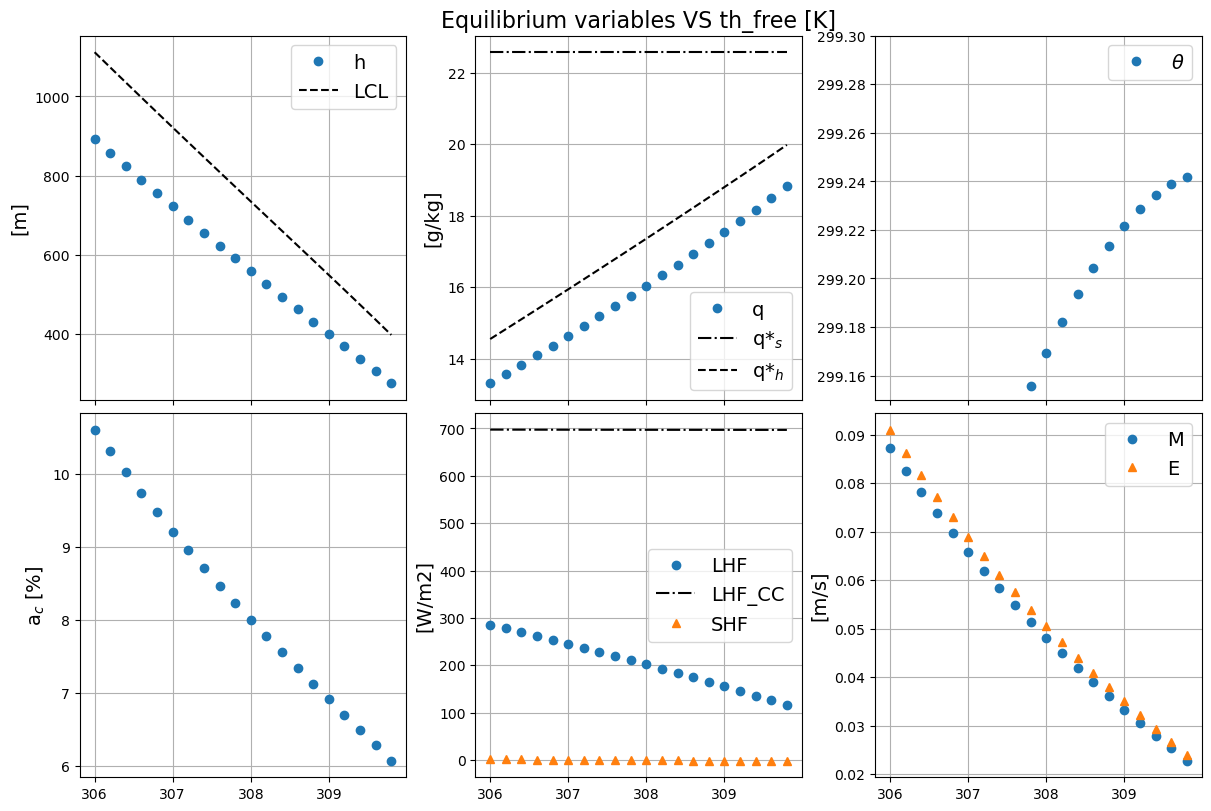

In [25]:
fig, ax = plt.subplots(2,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o',label='h')
ax[0,0].plot(list_of_values,LCL_eq,'--k',label='LCL')
ax[0,0].grid()
ax[0,0].set_ylabel('[m]',fontsize=14)
# ax[0,0].set_title('h and LCL', fontsize=12)
#ax[0,0].plot(dict_params[param_of_interest]['forcing_N06'],h_N06,'kv')
ax[0,0].legend(fontsize=14)

ax[0,1].plot(list_of_values,q_eq*1e3,'o',label='q')
ax[0,1].plot(list_of_values,qs_eq*1e3,'-.k',label='q*$_s$')
ax[0,1].plot(list_of_values,qsat_eq*1e3,'--k',label='q*$_h$')
ax[0,1].grid()
ax[0,1].set_ylabel('[g/kg]',fontsize=14)
#ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
#ax[0,1].plot(dict_params[param_of_interest]['forcing_N06'],q_N06,'kv')
ax[0,1].legend(fontsize=14)

ax[0,2].plot(list_of_values,th_eq,'o', label=r'$\theta$')
ax[0,2].grid()
# ax[0,2].set_ylabel('th [K]',fontsize=14)
#ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)
ax[0,2].set_ylim(299.15, 299.30)

ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
#ax[1,0].plot(dict_params[param_of_interest]['forcing_N06'],a_c_N06,'kv')

ax[1,1].plot(list_of_values,LHF_eq,'o',label='LHF')
ax[1,1].plot(list_of_values,LHF_CC_eq,'-.k',label='LHF_CC')
ax[1,1].plot(list_of_values,SHF_eq,'^',label='SHF')
ax[1,1].grid()
ax[1,1].set_ylabel('[W/m2]',fontsize=14)
ax[1,1].legend(fontsize=14)

ax[1,2].plot(list_of_values,M_eq,'o',label='M')
ax[1,2].plot(list_of_values,E_eq,'^',label='E')
ax[1,2].grid()
ax[1,2].set_ylabel('[m/s]',fontsize=14)
#ax[1,2].plot(dict_params[param_of_interest]['forcing_N06'],M_N06,'kv',label='N2006')
ax[1,2].legend(fontsize=14)

ax[0,1].set_title('Equilibrium variables VS '+param_of_interest+' ['+str_units+']',fontsize=16)

figure_name = 'equilibrium_variables_set2_dependence_on_' + param_of_interest + '.png'
# plt.savefig(figure_name,bbox_inches='tight')

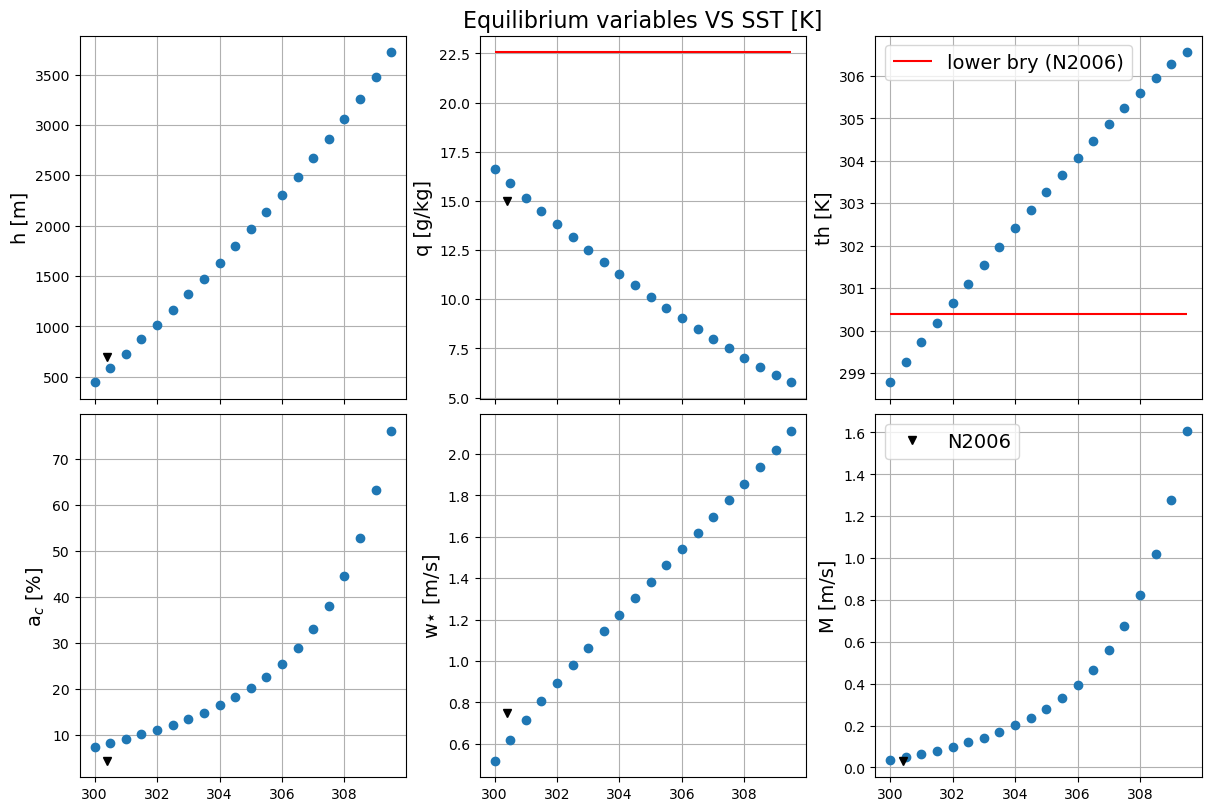

In [15]:
fig, ax = plt.subplots(2,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o')
ax[0,0].grid()
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].plot(dict_params[param_of_interest]['forcing_N06'],h_N06,'kv')

ax[0,1].plot(list_of_values,q_eq*1e3,'o')
ax[0,1].grid()
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
ax[0,1].plot(dict_params[param_of_interest]['forcing_N06'],q_N06,'kv')

ax[0,2].plot(list_of_values,th_eq,'o')
ax[0,2].grid()
ax[0,2].set_ylabel('th [K]',fontsize=14)
ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)

ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].plot(dict_params[param_of_interest]['forcing_N06'],a_c_N06,'kv')

ax[1,1].plot(list_of_values,w_star_eq,'o')
ax[1,1].grid()
ax[1,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[1,1].plot(dict_params[param_of_interest]['forcing_N06'],w_star_N06,'kv')

ax[1,2].plot(list_of_values,M_eq,'o')
ax[1,2].grid()
ax[1,2].set_ylabel('M [m/s]',fontsize=14)
ax[1,2].plot(dict_params[param_of_interest]['forcing_N06'],M_N06,'kv',label='N2006')
ax[1,2].legend(fontsize=14)

ax[0,1].set_title('Equilibrium variables VS '+param_of_interest+' ['+str_units+']',fontsize=16)

figure_name = 'equilibrium_variables_dependence_on_' + param_of_interest + '.png'
# plt.savefig(figure_name,bbox_inches='tight')

# Neggers 2006 + Stevens 2002 : add momentum equation

In [3]:
# Compute the wind components (to be used as free tropospheric wind) starting from the surface wind used in 
# Neggers et al (2006).
magnitude = 8.75 # [m/s]
angle = 67.5 # [°] clockwise from north
windu = magnitude*np.sin(angle*np.pi/180)
windv = magnitude*np.cos(angle*np.pi/180)
print(windu)
print(windv)

Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)

8.083945909473758
3.348480033194536


In [7]:
# t_final_NS/3600/len(dict_ext_NS_eqPert_cold['E_ext'])
U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
q_free = 10.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2,U_free,V_free]

# Input parameters
#V = 8.75 # [m/s], large scale horizontal wind -> no longer needed!
SST_0 = 300.4 # [K], sea surface temperature
D_0 = 4.3e-6 # [1/s], large scale divergence
q_free_0 = 10.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free_0 = 308 # [K], free tropospheric liquid virtual potential temperature
ps_0 = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0

dict_ext_NS = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }



###  choose which function to use to solve equations
# neggers_et_al_2006_stevens_et_al_2002 : full fine equations
# neggers_stevens_FracE : added a multiplying factor to E in the q and th equations
# 
sol_NS = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, time, y0, dense_output=True, max_step=dt_max, args=(SST_0, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS, 1))#, t_eval=t_eval)

/home/alessandro/thesis_material/EURECA_scripts/ABL_BULK/neggers_stevens.py:243: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


In [8]:
len(sol_NS.y[0])

8338

In [9]:
np.nanmax(dict_ext_NS['LCL_ext'])

1641.3386570848775

equilibrium h = 70.89655390184316 m
equilibrium q = 21.29167880193344 g/kg
equilibrium th = 299.04456967893367 K
equilibrium a$_c$ = 2.8567976834039555%
equilibrium w$^*$ = 0.15217476194574092 m/s


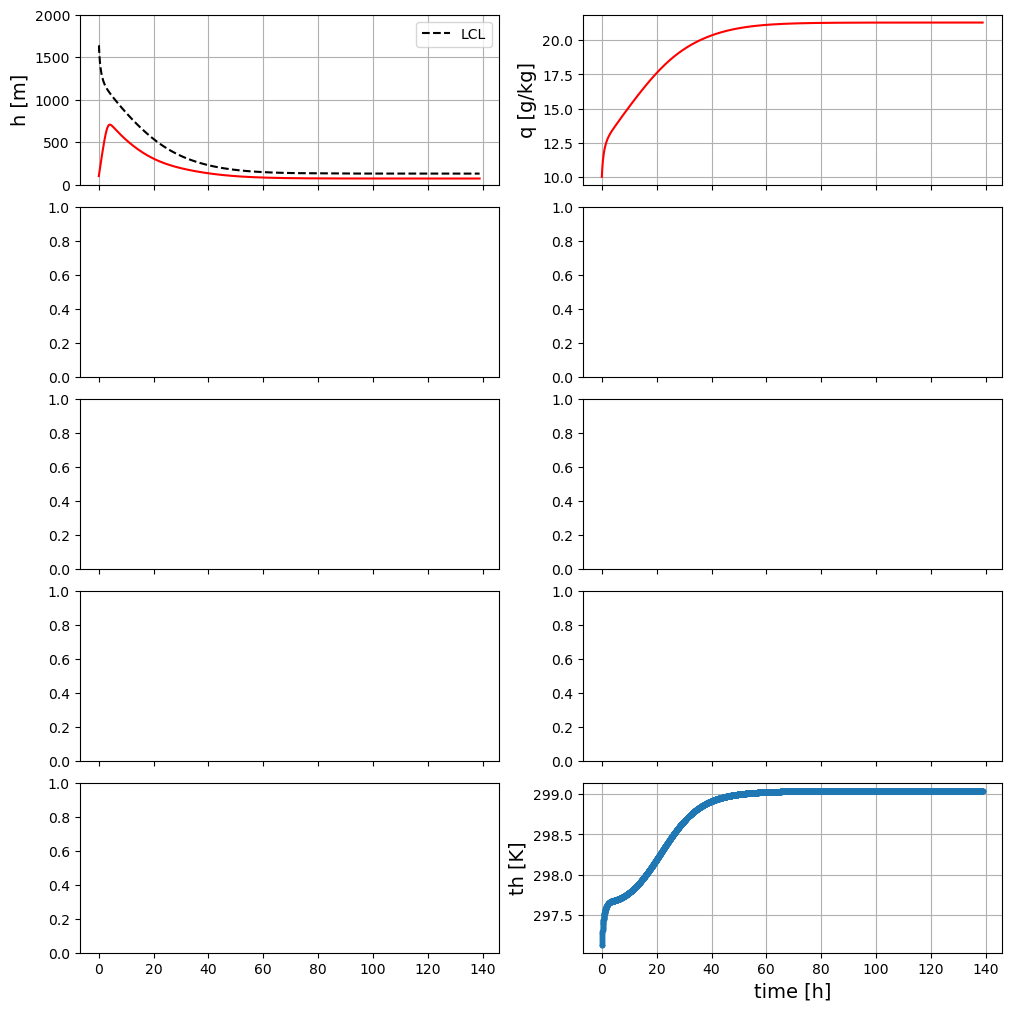

(0.0, 140.0)

In [10]:
# Plots for a single run.
h = sol_NS.y[0]
q = sol_NS.y[1]
th = sol_NS.y[2]
U = sol_NS.y[3]
V = sol_NS.y[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_NS = np.max(sol_NS.t)
dt_NS = t_final_NS/3600/len(dict_ext_NS['E_ext']) # [h]
time_ext_NS = np.arange(len(dict_ext_NS['E_ext']))*dt_NS

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(dict_ext_NS['area_c_ext'][-1]*100)+'%')
print('equilibrium w$^*$ = '+str(dict_ext_NS['w_star_ext'][-1])+' m/s')

fig, ax = plt.subplots(5,2,figsize=(10,10),sharex=True,constrained_layout=True)

# ax[0,0].plot(sol_N06.t/3600,h_CV,'k')
ax[0,0].plot(sol_NS.t/3600,h,'r')
ax[0,0].plot(time_ext_NS, np.array(dict_ext_NS['LCL_ext']),'--k', label='LCL')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()
ax[0,0].legend()

# ax[0,1].plot(sol_N06.t/3600,q_CV*1e3,'k')
ax[0,1].plot(sol_NS.t/3600,q*1e3,'r')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,1].set_ylim(0,20)
ax[0,1].grid()

plt.plot(sol_NS.t/3600,sol_NS.y[2],'.')
plt.ylabel('th [K]',fontsize=14)
plt.xlabel('time [h]',fontsize=14)
plt.grid()
plt.show()

# ax[1,0].plot(time_ext_N06,np.array(area_c_ext_CV)*100,'k')
ax[1,0].plot(time_ext_NS,np.array(dict_ext_NS['area_c_ext'])*100,'r')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()
# 
# ax[1,1].plot(time_ext_N06,np.array(LHF_ext_CV),'k')
ax[1,1].plot(time_ext_NS,np.array(dict_ext_NS['LHF_ext']),'r')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
# ax[1,1].set_ylim(0,500)
ax[1,1].grid()

# ax[2,0].plot(time_ext_N06,np.array(M_ext_CV),'k')
ax[2,0].plot(time_ext_NS,np.array(dict_ext_NS['M_ext']),'r')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.05)
ax[2,0].grid()

# ax[2,1].plot(time_ext_N06,np.array(sigma_q_ext_CV)*1e3,'k')
ax[2,1].plot(time_ext_NS,np.array(dict_ext_NS['sigma_q_ext'])*1e3,'r')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
# ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

# ax[3,0].plot(time_ext_N06,np.array(E_ext_CV),'k')
ax[3,0].plot(time_ext_NS,np.array(dict_ext_NS['E_ext']),'r')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.05)
ax[3,0].grid()

# ax[3,1].plot(time_ext_N06,np.array(w_star_ext_CV),'k')
ax[3,1].plot(time_ext_NS,np.array(dict_ext_NS['w_star_ext']),'r')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
# ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[4,0].hlines(U_free,np.min(sol_NS.t/3600),np.max(sol_NS.t/3600),'k',linestyle='dashed')
ax[4,0].plot(sol_NS.t/3600,U,'r')
ax[4,0].set_ylabel('U [m/s]',fontsize=14)
#ax[4,0].set_ylim(0,0.10)
ax[4,0].grid()

ax[4,1].hlines(V_free,np.min(sol_NS.t/3600),np.max(sol_NS.t/3600),'k',linestyle='dashed')
ax[4,1].plot(sol_NS.t/3600,V,'r')
ax[4,1].set_ylabel('V [m/s]',fontsize=14)
#ax[4,1].set_ylim(0,0.10)
ax[4,1].grid()

ax[4,0].set_xlabel('time [h]',fontsize=14)
ax[4,1].set_xlabel('time [h]',fontsize=14)
ax[4,0].set_xlim(0,140)
ax[4,1].set_xlim(0,140)

## once equilibrium is set, increase SST by 1K

In [74]:
U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3

y0 = [100, q_s - q_free, th_s-3, U_free, V_free]

# Input parameters
#V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
SST_0 = 300.4        # [K], sea surface temperature
D_0 = 4.3e-6         # [1/s], large scale divergence
q_free_0 = 4.0e-3    # [kg/kg] free tropospheric total mixing ratio
th_free_0 = 308      # [K], free tropospheric liquid virtual potential temperature
ps_0 = 1015          # [hPa], surface pressure


max_t = 7e5
dt_max = 60
time = [0, max_t]
factor_time = 0.5;  t_split = factor_time*max_t
# t_eval_eq = np.arange(0,t_split,dt_max)
# t_eval_cold_warm = np.arange(t_split,max_t,dt_max)


ii=0

dict_ext_NS_eq = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

dict_ext_NS_eqPert_cold = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }


## initial unperturbed arguments ##
args_initial = (SST_0, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eq, 1)


###  choose which function to use to solve equations
# neggers_et_al_2006_stevens_et_al_2002 : full fine equations
# neggers_stevens_FracE : added a multiplying factor to E in the q and th equations
sol_NS_eq = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, [0,t_split],  y0,\
                      dense_output=True, max_step=dt_max, args=args_initial)

y0_split = sol_NS_eq.y[:,-1]


#########   after reaching equilibrium , cool SST     ##########
args_modif_cold = (SST_0-1, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert_cold, 1)

sol_NS_eqPert_cold = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, [t_split,max_t], y0_split,\
                               dense_output=True, max_step=dt_max, args=args_modif_cold)


### concatenate solutions
# t_combined_cold, t_combined_warm = np.concatenate((sol_NS_eq.t, sol_NS_eqPert_cold.t)), np.concatenate((sol_NS_eq.t, sol_NS_eqPert_warm.t))
# y_combined_cold, y_combined_warm = np.hstack((sol_NS_eq.y, sol_NS_eqPert_cold.y)), np.hstack((sol_NS_eq.y, sol_NS_eqPert_warm.y))

In [75]:
dict_ext_NS_eqPert_warm = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

#########   after reaching equilibrium , warm SST     ##########
args_modif_warm = (SST_0+1, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert_warm, 1)

sol_NS_eqPert_warm = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, [t_split,max_t],  y0_split,\
                               dense_output=True, max_step=dt_max, args=args_modif_warm)

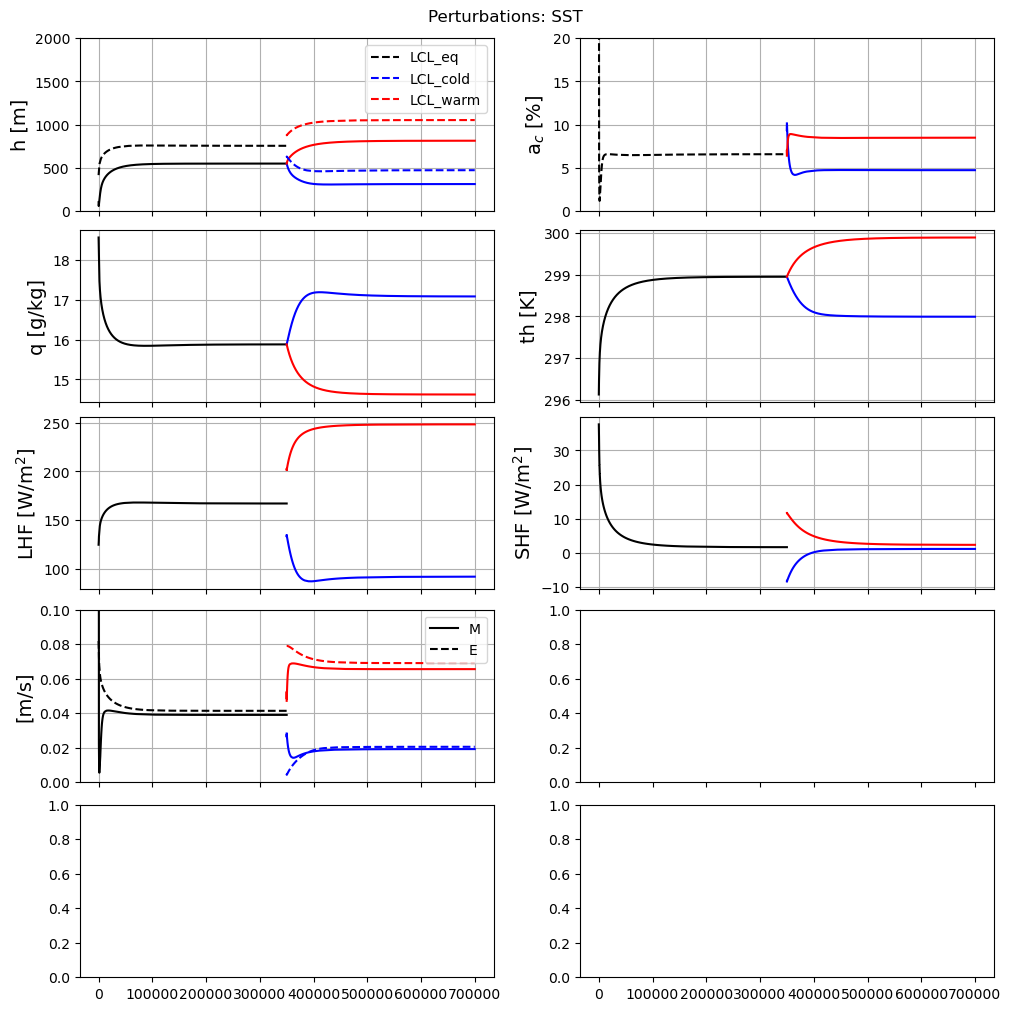

In [80]:
h_eq, h_cold, h_warm   =  sol_NS_eq.y[0], sol_NS_eqPert_cold.y[0], sol_NS_eqPert_warm.y[0]   ##  y_combined[0]
q_eq, q_cold, q_warm =  sol_NS_eq.y[1], sol_NS_eqPert_cold.y[1], sol_NS_eqPert_warm.y[1]   #y_combined[1]
th_eq, th_cold, th_warm = sol_NS_eq.y[2], sol_NS_eqPert_cold.y[2], sol_NS_eqPert_warm.y[2]   #y_combined[2]
U_eq, U_cold, U_warm =  sol_NS_eq.y[3], sol_NS_eqPert_cold.y[3], sol_NS_eqPert_warm.y[3]   #y_combined[3]
V_eq, V_cold, V_warm =  sol_NS_eq.y[4], sol_NS_eqPert_cold.y[4], sol_NS_eqPert_warm.y[4]   #y_combined[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_NS_eq, t_final_NS_cold, t_final_NS_warm = np.max(sol_NS_eq.t),\
                                                  np.max(sol_NS_eqPert_cold.t),\
                                                  np.max(sol_NS_eqPert_warm.t)

dt_NS_eq, dt_NS_cold, dt_NS_warm = t_final_NS_eq   / len(dict_ext_NS_eq['E_ext']),\
                                   (t_final_NS_cold - t_final_NS_eq) / len(dict_ext_NS_eqPert_cold['E_ext']),\
                                   (t_final_NS_warm - t_final_NS_eq) / len(dict_ext_NS_eqPert_warm['E_ext']) # [h]

time_ext_NS_eq   = np.arange(len(dict_ext_NS_eq['E_ext']))* dt_NS_eq
time_ext_NS_cold = np.arange(len(dict_ext_NS_eqPert_cold['E_ext']), len(dict_ext_NS_eqPert_cold['E_ext']) / factor_time) * dt_NS_cold
time_ext_NS_warm = np.arange(len(dict_ext_NS_eqPert_warm['E_ext']), len(dict_ext_NS_eqPert_warm['E_ext']) / factor_time) * dt_NS_warm

# print('equilibrium h = '+str(h[-1])+' m')
# print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
# print('equilibrium th = ' +str(th[-1])+' K')
# print('equilibrium a$_c$ = '+str(dict_ext_NS_eqPert['area_c_ext'][-1]*100)+'%')
# print('equilibrium w$^*$ = '+str(dict_ext_NS_eqPert['w_star_ext'][-1])+' m/s')

fig, ax = plt.subplots(5,2,figsize=(10,10),sharex=True,constrained_layout=True)
fig.suptitle('Perturbations: SST')
import matplotlib.lines as mlines


#################  h and LCL  ##################

# ax[0,0].plot(sol_N06.t,h_CV,'k')
ax[0,0].plot(sol_NS_eq.t,h_eq,'k')
ax[0,0].plot(sol_NS_eqPert_cold.t,h_cold,'blue')
ax[0,0].plot(sol_NS_eqPert_warm.t,h_warm,'r')
## LCL ##
ax[0,0].plot(time_ext_NS_eq, np.array(dict_ext_NS_eq['LCL_ext']),'--k', label='LCL_eq')
ax[0,0].plot(time_ext_NS_cold, np.array(dict_ext_NS_eqPert_cold['LCL_ext']),'--b', label='LCL_cold')
ax[0,0].plot(time_ext_NS_warm, np.array(dict_ext_NS_eqPert_warm['LCL_ext']),'--r', label='LCL_warm')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()
ax[0,0].legend()



#####  convective area  ####
ax[0,1].plot(time_ext_NS_eq, np.array(dict_ext_NS_eq['area_c_ext'])*100,'--k', label='ac_eq')
ax[0,1].plot(time_ext_NS_cold, np.array(dict_ext_NS_eqPert_cold['area_c_ext'])*100,'b', label='ac_cold')
ax[0,1].plot(time_ext_NS_warm, np.array(dict_ext_NS_eqPert_warm['area_c_ext'])*100,'r', label='ac_warm')
ax[0,1].set_ylabel('a$_c$ [%]',fontsize=14)
ax[0,1].set_ylim(0,20)
ax[0,1].grid()


##### temperature  ######
ax[1,1].plot(sol_NS_eq.t,th_eq,'k')
ax[1,1].plot(sol_NS_eqPert_cold.t,th_cold,'blue')
ax[1,1].plot(sol_NS_eqPert_warm.t,th_warm,'r')
ax[1,1].set_ylabel('th [K]',fontsize=14)
# ax[1,1].set_ylim(0,20)
ax[1,1].grid()


############## moisture  ##########
# ax[0,1].plot(sol_N06.t,q_CV*1e3,'k')
ax[1,0].plot(sol_NS_eq.t,q_eq*1e3,'k')
ax[1,0].plot(sol_NS_eqPert_cold.t,q_cold*1e3,'blue')
ax[1,0].plot(sol_NS_eqPert_warm.t,q_warm*1e3,'r')
ax[1,0].set_ylabel('q [g/kg]',fontsize=14)
# ax[1,0].set_ylim(0,20)
ax[1,0].grid()


# # ax[1,0].plot(time_ext_N06,np.array(area_c_ext_CV)*100,'k')
# ax[1,0].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['area_c_ext'])*100,'r')


######  LHF  #####
ax[2,0].plot(time_ext_NS_eq, np.array(dict_ext_NS_eq['LHF_ext']),'k', label='LHF_eq')
ax[2,0].plot(time_ext_NS_cold, np.array(dict_ext_NS_eqPert_cold['LHF_ext']),'b', label='LHF_cold')
ax[2,0].plot(time_ext_NS_warm, np.array(dict_ext_NS_eqPert_warm['LHF_ext']),'r', label='LHF_warm')
ax[2,0].set_ylabel('LHF [W/m$^2$]',fontsize=14)
# ax[2,0].set_ylim(0,500)
ax[2,0].grid()

######  LHF  #####
ax[2,1].plot(time_ext_NS_eq, np.array(dict_ext_NS_eq['SHF_ext']),'k', label='SHF_eq')
ax[2,1].plot(time_ext_NS_cold, np.array(dict_ext_NS_eqPert_cold['SHF_ext']),'b', label='SHF_cold')
ax[2,1].plot(time_ext_NS_warm, np.array(dict_ext_NS_eqPert_warm['SHF_ext']),'r', label='SHF_warm')
ax[2,1].set_ylabel('SHF [W/m$^2$]',fontsize=14)
# ax[2,1].set_ylim(0,500)
ax[2,1].grid()




#########  M and E  ############
# Create custom legend handles for solid and dashed lines
solid_line = mlines.Line2D([], [], color='k', label='M', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='E', linestyle='--')
ax[3,0].plot(time_ext_NS_eq, np.array(dict_ext_NS_eq['M_ext']),'k', label='M_eq')
ax[3,0].plot(time_ext_NS_cold, np.array(dict_ext_NS_eqPert_cold['M_ext']),'b', label='M_cold')
ax[3,0].plot(time_ext_NS_warm, np.array(dict_ext_NS_eqPert_warm['M_ext']),'r', label='M_warm')

ax[3,0].plot(time_ext_NS_eq, np.array(dict_ext_NS_eq['E_ext']),'--k', label='E_eq')
ax[3,0].plot(time_ext_NS_cold, np.array(dict_ext_NS_eqPert_cold['E_ext']),'--b', label='E_cold')
ax[3,0].plot(time_ext_NS_warm, np.array(dict_ext_NS_eqPert_warm['E_ext']),'--r', label='E_warm')
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()
ax[3,0].legend(handles=[solid_line, dashed_line])
ax[3,0].set_ylabel('[m/s]',fontsize=14)


# # ax[2,1].plot(time_ext_N06,np.array(sigma_q_ext_CV)*1e3,'k')
# ax[2,1].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['sigma_q_ext'])*1e3,'r')
# ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
# # ax[2,1].set_ylim(0,1.5)
# ax[2,1].grid()

# # ax[3,0].plot(time_ext_N06,np.array(E_ext_CV),'k')
# ax[3,0].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['E_ext']),'r')
# ax[3,0].set_ylabel('E [m/s]',fontsize=14)


# # ax[3,1].plot(time_ext_N06,np.array(w_star_ext_CV),'k')
# ax[3,1].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['w_star_ext']),'r')
# ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
# # ax[3,1].set_ylim(0.4,1.2)
# ax[3,1].grid()

# ax[4,0].hlines(U_free,np.min(sol_NS_eq.t),np.max(sol_NS_eq.t),'k',linestyle='dashed')
# ax[4,0].plot(sol_NS_eq.t,U,'r')
# ax[4,0].set_ylabel('U [m/s]',fontsize=14)
# #ax[4,0].set_ylim(0,0.10)
# ax[4,0].grid()

# ax[4,1].hlines(V_free,np.min(sol_NS_eq.t),np.max(sol_NS_eq.t),'k',linestyle='dashed')
# ax[4,1].plot(sol_NS_eq.t,V,'r')
# ax[4,1].set_ylabel('V [m/s]',fontsize=14)
# #ax[4,1].set_ylim(0,0.10)
# ax[4,1].grid()

# ax[4,0].set_xlabel('time [h]',fontsize=14)
# ax[4,1].set_xlabel('time [h]',fontsize=14)
# ax[4,0].set_xlim(25,200)
# ax[4,1].set_xlim(25,200)


filename = '/venus/tesi_ale/img_bulk/SST_minus1.pdf'
# plt.savefig(filename)
del filename

## increase or decrease SST one time at a time

In [9]:
U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
# q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3


# Input parameters
#V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
SST_0 = 300.4        # [K], sea surface temperature
D_0 = 4.3e-6         # [1/s], large scale divergence
q_free_0 = 4.0e-3    # [kg/kg] free tropospheric total mixing ratio
th_free_0 = 308      # [K], free tropospheric liquid virtual potential temperature
ps_0 = 1015          # [hPa], surface pressure


y0 = [100, q_s - q_free_0, th_s-3, U_free, V_free]

max_t = 7e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)
t_split = 0.5*max_t

ii=0

dict_ext_NS_eqPert = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }


## initial unperturbed arguments ##
args_initial = (SST_0, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert, 1)


###  choose which function to use to solve equations
# neggers_et_al_2006_stevens_et_al_2002 : full fine equations
# neggers_stevens_FracE : added a multiplying factor to E in the q and th equations
# 
sol_NS_eq = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, (0,t_split), y0,\
                      dense_output=True, max_step=dt_max, args=args_initial)

y0_split = sol_NS_eq.y[:,-1]


#########   after reaching equilibrium , cool SST     ##########
args_modif = (SST_0-1, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert, 1)

sol_NS_eqPert = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, (t_split,max_t), y0_split,\
                               dense_output=True, max_step=dt_max, args=args_modif)

### concatenate solutions
t_combined = np.concatenate((sol_NS_eq.t, sol_NS_eqPert.t))
y_combined = np.hstack((sol_NS_eq.y, sol_NS_eqPert.y))

equilibrium h = 310.270135457151 m
equilibrium q = 17.08594317574244 g/kg
equilibrium th = 297.99298064421185 K
equilibrium a$_c$ = 4.711632858567826%
equilibrium w$^*$ = 0.4076009272019156 m/s


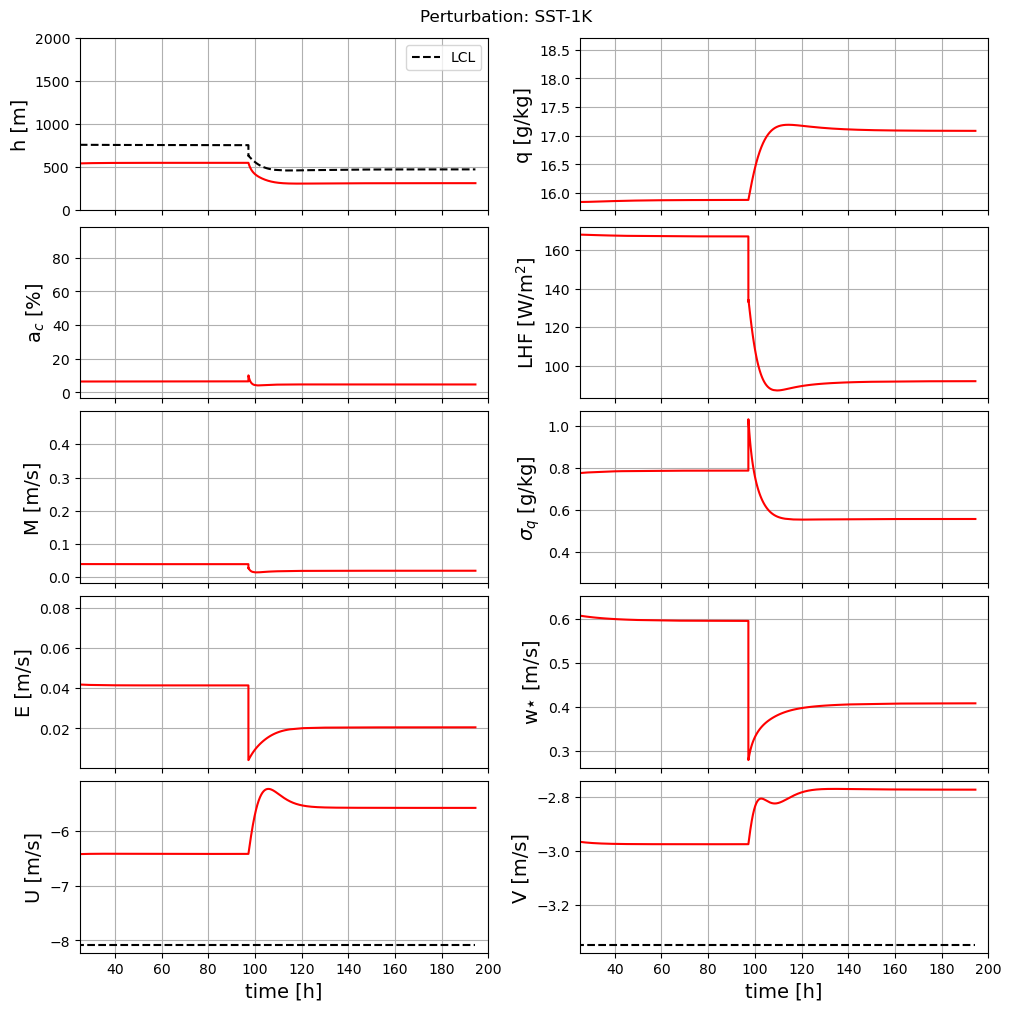

In [11]:
# Plots for a single run.
# h = sol_NS_eqPert.y[0]
# q = sol_NS_eqPert.y[1]
# th = sol_NS_eqPert.y[2]
# U = sol_NS_eqPert.y[3]
# V = sol_NS_eqPert.y[4]

h =  y_combined[0]
q =  y_combined[1]
th = y_combined[2]
U =  y_combined[3]
V =  y_combined[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_NS = np.max(t_combined)
dt_NS = t_final_NS/3600/len(dict_ext_NS_eqPert['E_ext']) # [h]
time_ext_NS = np.arange(len(dict_ext_NS_eqPert['E_ext']))*dt_NS

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(dict_ext_NS_eqPert['area_c_ext'][-1]*100)+'%')
print('equilibrium w$^*$ = '+str(dict_ext_NS_eqPert['w_star_ext'][-1])+' m/s')

fig, ax = plt.subplots(5,2,figsize=(10,10),sharex=True,constrained_layout=True)
fig.suptitle('Perturbation: SST-1K')

# ax[0,0].plot(sol_N06.t/3600,h_CV,'k')
ax[0,0].plot(t_combined/3600,h,'r')
ax[0,0].plot(time_ext_NS, np.array(dict_ext_NS_eqPert['LCL_ext']),'--k', label='LCL')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()
ax[0,0].legend()

# ax[0,1].plot(sol_N06.t/3600,q_CV*1e3,'k')
ax[0,1].plot(t_combined/3600,q*1e3,'r')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,1].set_ylim(0,20)
ax[0,1].grid()

#plt.plot(t_combined/3600,sol_NS.y[2],'.')
#plt.ylabel('th [K]',fontsize=14)
#plt.xlabel('time [h]',fontsize=14)
#plt.grid()
#plt.show()

# ax[1,0].plot(time_ext_N06,np.array(area_c_ext_CV)*100,'k')
ax[1,0].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['area_c_ext'])*100,'r')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
# ax[1,0].set_ylim(0,20)
ax[1,0].grid()
# 
# ax[1,1].plot(time_ext_N06,np.array(LHF_ext_CV),'k')
ax[1,1].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['LHF_ext']),'r')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
# ax[1,1].set_ylim(0,500)
ax[1,1].grid()

# ax[2,0].plot(time_ext_N06,np.array(M_ext_CV),'k')
ax[2,0].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['M_ext']),'r')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
# ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

# ax[2,1].plot(time_ext_N06,np.array(sigma_q_ext_CV)*1e3,'k')
ax[2,1].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['sigma_q_ext'])*1e3,'r')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
# ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

# ax[3,0].plot(time_ext_N06,np.array(E_ext_CV),'k')
ax[3,0].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['E_ext']),'r')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
# ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

# ax[3,1].plot(time_ext_N06,np.array(w_star_ext_CV),'k')
ax[3,1].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['w_star_ext']),'r')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
# ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[4,0].hlines(U_free,np.min(t_combined/3600),np.max(t_combined/3600),'k',linestyle='dashed')
ax[4,0].plot(t_combined/3600,U,'r')
ax[4,0].set_ylabel('U [m/s]',fontsize=14)
#ax[4,0].set_ylim(0,0.10)
ax[4,0].grid()

ax[4,1].hlines(V_free,np.min(t_combined/3600),np.max(t_combined/3600),'k',linestyle='dashed')
ax[4,1].plot(t_combined/3600,V,'r')
ax[4,1].set_ylabel('V [m/s]',fontsize=14)
#ax[4,1].set_ylim(0,0.10)
ax[4,1].grid()

ax[4,0].set_xlabel('time [h]',fontsize=14)
ax[4,1].set_xlabel('time [h]',fontsize=14)
ax[4,0].set_xlim(25,200)
ax[4,1].set_xlim(25,200)


filename = '/venus/tesi_ale/img_bulk/SST_minus1.pdf'
# plt.savefig(filename)
del filename

## run sensitivity tests on results from Neggers + Stevens also

In [41]:
# Now test the dependence of the solution to some external parameters.

# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3                   # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67                    # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1                        # J/K/kg, dry air gas constant
SST = 300.4                       # K
ps = 1015                         # [hPa], surface pressure
ref_p = 1000                      # [hPa], reference pressure for the potential temperature
th_s = SST*(ref_p/ps)**(Rd/cpd)   # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3

y0 = [100,q_s - q_free, th_s-2, U_free+3, V_free]

# Input parameters
V = 8.75         # [m/s], large scale horizontal wind
SST = 300.4      # [K], sea surface temperature
D = 4.3e-6       # [1/s], large scale divergence
q_free = 4.0e-3  # [kg/kg] free tropospheric total mixing ratio
th_free = 308    # [K], free tropospheric liquid virtual potential temperature
ps = 1015        # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

# Neggers et al. (2006) forcing values...
U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

SST = 300.4                       # [K], sea surface temperature
D = 4.3e-6                        # [1/s], large scale divergence
q_free = 4.0e-3                   # [kg/kg] free tropospheric total mixing ratio
th_free = 308                     # [K], free tropospheric liquid virtual potential temperature
ps = 1015                         # [hPa], surface pressure
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3


# ... and equilibrium values
h_N06 = 692               # m
q_N06 = 15                # g/kg 
a_c_N06 = 4.3             # %
w_star_N06 = 0.75         # m/s
M_N06 = 0.032             # m/s


dict_params = {
        'SST': {'values': np.arange(300,303,0.1), 'units': 'K'},# 'forcing_N06': SST_N06},
        'U_free': {'values': np.arange(U_free-5,U_free+5, 1), 'units': 'm/s'}, #'forcing_N06': V_N06},
        'V_free': {'values': np.arange(V_free-5,V_free+5, 0.5), 'units': 'm/s'}, # 'forcing_N06': V_N06},
        'D': {'values': np.arange(2.5,6.5,0.25)*1e-6, 'units': '1/s'}, # 'forcing_N06': D_N06},
        'q_free': {'values': np.arange(0.5e-3,4.0e-3,0.2e-3), 'units': 'kg/kg'}, # 'forcing_N06': q_free_N06},
        'th_free': {'values': np.arange(306,310, 0.2), 'units': 'K'}, # 'forcing_N06': th_free_N06},
        'ps': {'values': np.arange(1000,1030,5), 'units': 'hPa'}, # 'forcing_N06': ps_N06}
}

param_of_interest = 'U_free'
list_of_values = dict_params[param_of_interest]['values']
str_units = dict_params[param_of_interest]['units']

#---------
h_eq = np.zeros((len(list_of_values),))
q_eq = h_eq.copy()
th_eq = h_eq.copy()
U_eq, V_eq = h_eq.copy(), h_eq.copy()
a_c_eq = h_eq.copy()
w_star_eq = h_eq.copy()
we_dyn_eq = h_eq.copy()
M_eq = h_eq.copy()
E_eq = h_eq.copy()
LHF_eq = h_eq.copy()
LHF_CC_eq = h_eq.copy()
qs_eq = h_eq.copy()
qsat_eq = h_eq.copy()
SHF_eq = h_eq.copy()
LCL_eq = h_eq.copy()

for jj,U_free in enumerate(list_of_values):
    ii=0
    
    
    dict_ext = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[], 'LHF_ext':[], 'LHF_CC_ext':[], 'qs_ext':[], 'qsat_ext':[],\
                'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[], 'b_flux_s_NoG_ext':[]}

    sol = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, time, y0, dense_output=True, max_step=dt_max, args=(SST,D,q_free,th_free,ps,f,U_free,V_free,we, dict_ext))#, t_eval=t_eval)
    h_eq[jj] = sol.y[0][-1]
    LCL_eq[jj] = dict_ext['LCL_ext'][-1]       if len(dict_ext['LCL_ext']) is not 0 else 999
    
    q_eq[jj] = sol.y[1][-1]
    th_eq[jj] = sol.y[2][-1]
    U_eq[jj] = sol.y[3][-1]
    V_eq[jj] = sol.y[4][-1]
    
    a_c_eq[jj] = dict_ext['area_c_ext'][-1]    if len(dict_ext['area_c_ext']) is not 0 else 999
    w_star_eq[jj] = dict_ext['w_star_ext'][-1] if len(dict_ext['w_star_ext']) is not 0 else 999
    we_dyn_eq[jj] = dict_ext['we_dyn_ext'][-1] if len(dict_ext['we_dyn_ext']) is not 0 else 999
    M_eq[jj] = dict_ext['M_ext'][-1]           if len(dict_ext['M_ext']) is not 0 else 999
    E_eq[jj] = dict_ext['E_ext'][-1]           if len(dict_ext['E_ext']) is not 0 else 999
    
    LHF_eq[jj] = dict_ext['LHF_ext'][-1]       if len(dict_ext['LHF_ext']) is not 0 else 999
    LHF_CC_eq[jj] = dict_ext['LHF_CC_ext'][-1] if len(dict_ext['LHF_CC_ext']) is not 0 else 999
    SHF_eq[jj] = dict_ext['SHF_ext'][-1]       if len(dict_ext['SHF_ext']) is not 0 else 999
    
    qs_eq[jj] = dict_ext['qs_ext'][-1]         if len(dict_ext['qs_ext']) is not 0 else 999
    qsat_eq[jj] = dict_ext['qsat_ext'][-1]     if len(dict_ext['qsat_ext']) is not 0 else 999
    
    
    
    if (np.round(100*(jj+1)/len(list_of_values)%10 == 0)):
        print(str(np.round(100*(jj+1)/len(list_of_values)))+' percent')
        print('---------------------------------------')

10.0 percent
---------------------------------------
20.0 percent
---------------------------------------
30.0 percent
---------------------------------------
40.0 percent
---------------------------------------
50.0 percent
---------------------------------------
60.0 percent
---------------------------------------
70.0 percent
---------------------------------------
80.0 percent
---------------------------------------
90.0 percent
---------------------------------------
100.0 percent
---------------------------------------


In [24]:
qsat_eq

array([0.01764035, 0.0175371 , 0.01743151, 0.01732376, 0.01721402,
       0.01710244, 0.01698914, 0.01687425, 0.01675787, 0.01664011,
       0.01652105, 0.01640077, 0.01627934, 0.01615684, 0.01603333,
       0.01590886, 0.0157835 , 0.01565729, 0.01553027, 0.0154025 ,
       0.01527402, 0.01514487, 0.01501508, 0.01488469, 0.01475374,
       0.01462226, 0.01449027, 0.01435782, 0.01422492, 0.01409161])

/home/alessandro/miniconda3/envs/spec_tesi_clone/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb7cab62d50> has a label of '_line0' which cannot be automatically added to the legend.


Prandtl Number trend: 0.835169323970541  to  0.8027640404344646



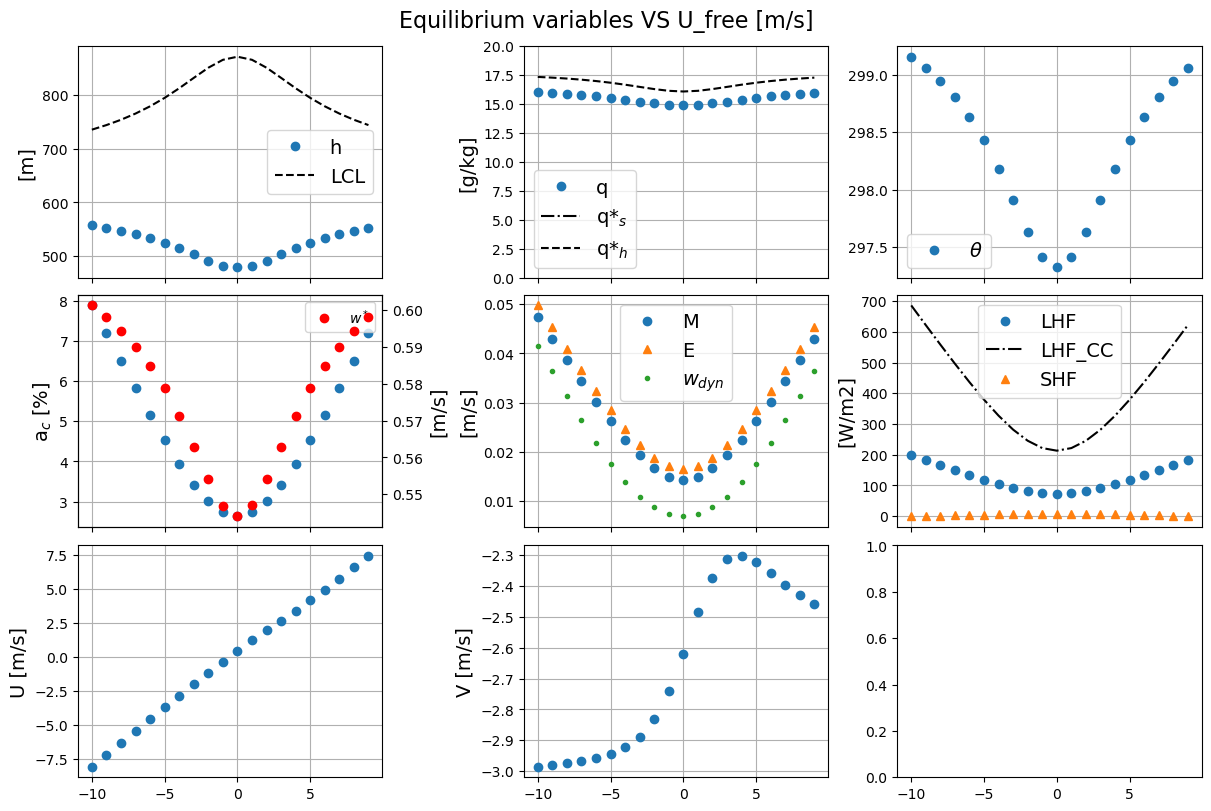

In [42]:
fig, ax = plt.subplots(3,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o',label='h')
ax[0,0].plot(list_of_values,LCL_eq,'--k',label='LCL')
ax[0,0].grid()
ax[0,0].set_ylabel('[m]',fontsize=14)
# ax[0,0].set_title('h and LCL', fontsize=12)
#ax[0,0].plot(dict_params[param_of_interest]['forcing_N06'],h_N06,'kv')
ax[0,0].legend(fontsize=14)

ax[0,1].plot(list_of_values,q_eq*1e3,'o',label='q')
ax[0,1].plot(list_of_values,qs_eq*1e3,'-.k',label='q*$_s$')
ax[0,1].plot(list_of_values,qsat_eq*1e3,'--k',label='q*$_h$')
ax[0,1].grid()
ax[0,1].set_ylabel('[g/kg]',fontsize=14)
#ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
#ax[0,1].plot(dict_params[param_of_interest]['forcing_N06'],q_N06,'kv')
ax[0,1].legend(fontsize=14)
ax[0,1].set_ylim(0,20)

ax[0,2].plot(list_of_values,th_eq,'o', label=r'$\theta$')
ax[0,2].grid()
# ax[0,2].set_ylabel('th [K]',fontsize=14)
#ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)
# ax[0,2].set_ylim(299.15, 299.30)


#####  components of Mass Flux  (M)
line1 = ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)

axino = ax[1,0].twinx()

line2 = axino.plot(list_of_values, w_star_eq, 'or', label=r'$w^*$')
axino.set_ylabel('[m/s]',fontsize=14)
ln = line1+line2
labs = [l.get_label() for l in ln]
ax[1, 0].legend(ln, labs, loc='best')






ax[1,1].plot(list_of_values,M_eq,'o',label='M')
ax[1,1].plot(list_of_values,E_eq,'^',label='E')
ax[1,1].plot(list_of_values,we_dyn_eq,'.',label=r'$w_{dyn}$')
ax[1,1].grid()
ax[1,1].set_ylabel('[m/s]',fontsize=14)
#ax[1,1].plot(dict_params[param_of_interest]['forcing_N06'],M_N06,'kv',label='N2006')
ax[1,1].legend(fontsize=14)

ax[1,2].plot(list_of_values,LHF_eq,'o',label='LHF')
ax[1,2].plot(list_of_values,LHF_CC_eq,'-.k',label='LHF_CC')
ax[1,2].plot(list_of_values,SHF_eq,'^',label='SHF')
ax[1,2].grid()
ax[1,2].set_ylabel('[W/m2]',fontsize=14)
ax[1,2].legend(fontsize=14)

ax[2,0].plot(list_of_values, U_eq, 'o', label='M')
ax[2,0].set_ylabel('U [m/s]',fontsize=14)
#ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(list_of_values, V_eq, 'o', label='M')
ax[2,1].set_ylabel('V [m/s]',fontsize=14)
#ax[2,1].set_ylim(0,0.10)
ax[2,1].grid()


fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+']',fontsize=16)

# figure_name = 'equilibrium_variables_set2_dependence_on_' + param_of_interest + '.png'
# plt.savefig(figure_name,bbox_inches='tight')


###########################################à


print(f'Prandtl Number trend: {(we_dyn_eq/E_eq)[0]}  to  {(we_dyn_eq/E_eq)[-1]}')
print()




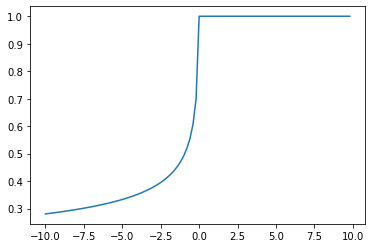

In [11]:
def prt_dyer74(zL):
    if zL>0:
        return 1
    else:
        return 1/(1-16*zL)**0.25

zL = np.arange(-10,10,0.2)
Prt = np.zeros((len(zL),))
for ii,z in enumerate(zL):
    Prt[ii] = prt_dyer74(z)
    
plt.plot(zL,Prt)